# Breast Cancer

**Data Set Information:**

There are two classes (binary classification): “no-recurrence-events” and “recurrence-events”, that describe whether the patient’s cancer reappeared after treatment. The other 9 attributes contain general information about the patients themselves as well as more specific information about their individual cancer diagnoses. Using this information the goal is to classify whether a patient will have breast cancer again, or not


**Attribute Information:**

**- Class:** Describes if a patient had recurrent tumors;<br>
**- age:** Age listed in Interval of 10 years;<br>
**- menopause:** Nominal Short text description;<br>
**- tumor-size:** Interval in which falls the diamater of tumor falls;<br>
**- inv-nodes:** Interval in which falls the number of lymph-nodes in close proximity of the tumor;<br>
**- node-caps:** Nominal Describe whenever there're metastases or not;<br>
**- deg-malig:** Numerical Describe how bad the cancer is;<br>
**- breast:** Nominal Describe the afflicted breast;<br>
**- breast-quad:** Nominal Text representing the location of  tumor in the breast.<br>
**- irradiate** Nominal yes/no Indicates whenever the patient underwent radiation therapy.

### Import Libraries

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Get the data

In [195]:
data = pd.read_csv('breast-cancer.csv')

In [196]:
data

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,'40-49','premeno','15-19','0-2','yes','3','right','left_up','no','recurrence-events'
1,'50-59','ge40','15-19','0-2','no','1','right','central','no','no-recurrence-events'
2,'50-59','ge40','35-39','0-2','no','2','left','left_low','no','recurrence-events'
3,'40-49','premeno','35-39','0-2','yes','3','right','left_low','yes','no-recurrence-events'
4,'40-49','premeno','30-34','3-5','yes','2','left','right_up','no','recurrence-events'
...,...,...,...,...,...,...,...,...,...,...
281,'50-59','ge40','30-34','6-8','yes','2','left','left_low','no','no-recurrence-events'
282,'50-59','premeno','25-29','3-5','yes','2','left','left_low','yes','no-recurrence-events'
283,'30-39','premeno','30-34','6-8','yes','2','right','right_up','no','no-recurrence-events'
284,'50-59','premeno','15-19','0-2','no','2','right','left_low','no','no-recurrence-events'


*Remove quotation marks*

In [197]:
for column in data:
    data[column] = data[column].map(lambda x: x.lstrip("'").rstrip("'"))


In [198]:
data.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events


### Basic Data Information

In [199]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          286 non-null    object
 1   menopause    286 non-null    object
 2   tumor-size   286 non-null    object
 3   inv-nodes    286 non-null    object
 4   node-caps    286 non-null    object
 5   deg-malig    286 non-null    object
 6   breast       286 non-null    object
 7   breast-quad  286 non-null    object
 8   irradiat     286 non-null    object
 9   Class        286 non-null    object
dtypes: object(10)
memory usage: 11.2+ KB


In [200]:
data.describe()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
count,286,286,286,286,286,286,286,286,286,286
unique,6,3,11,7,3,3,2,6,2,2
top,50-59,premeno,30-34,0-2,no,2,left,left_low,no,no-recurrence-events
freq,96,150,60,213,222,130,152,110,218,201


### Check missing values

In [201]:
data.loc[(data['age'] == '?') | (data['menopause'] == '?') | \
         (data['tumor-size'] == '?') | (data['inv-nodes'] == '?') | \
         (data['node-caps'] == '?') | (data['deg-malig'] == '?') | \
         (data['breast'] == '?') | (data['breast-quad'] == '?') | \
         (data['irradiat'] == '?') | (data['Class'] == '?')] 

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
20,50-59,lt40,20-24,0-2,?,1,left,left_low,no,recurrence-events
31,60-69,ge40,25-29,3-5,?,1,right,left_low,yes,no-recurrence-events
50,70-79,ge40,15-19,9-11,?,1,left,left_low,yes,recurrence-events
54,40-49,premeno,25-29,0-2,?,2,left,right_low,yes,no-recurrence-events
71,60-69,ge40,25-29,3-5,?,1,right,left_up,yes,no-recurrence-events
92,50-59,lt40,20-24,0-2,?,1,left,left_up,no,recurrence-events
149,50-59,ge40,30-34,9-11,?,3,left,left_up,yes,no-recurrence-events
240,50-59,ge40,30-34,0-2,no,3,left,?,no,recurrence-events
264,50-59,ge40,30-34,9-11,?,3,left,left_low,yes,no-recurrence-events


*Convert missing data (indicated by a ?) into NaN*

In [206]:
data.replace("?", np.nan, inplace = True)
data = data.dropna(axis = 0, how ='any') 

In [207]:
print(data.isnull().sum())

age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
Class          0
dtype: int64


# Exploratory Data Analysis

In [161]:
c_palette = ['tab:red','tab:green']

*Countplot of the Target* 

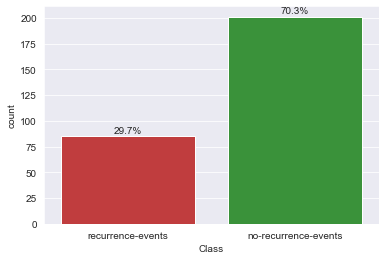

In [162]:
sns.set_style('darkgrid')
ax = sns.countplot(x = data['Class'], palette=c_palette)

total = len(data['Class'])

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:.1f}%'.format(100 * height/total),
            ha="center")

**Class on Age Interval**

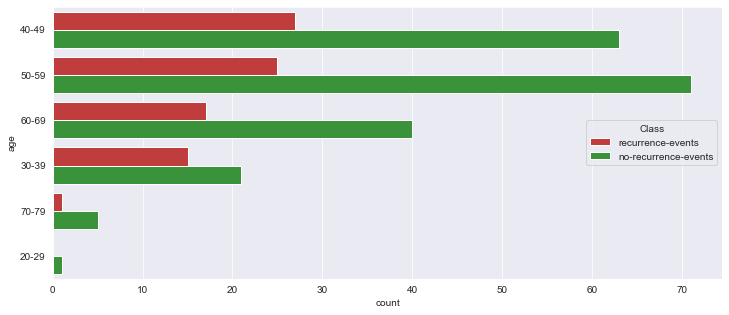

In [14]:
plt.figure(figsize=(12, 5))
sns.countplot(y="age", hue="Class", data=data, palette=c_palette)
plt.show()

**Class on Menopause**

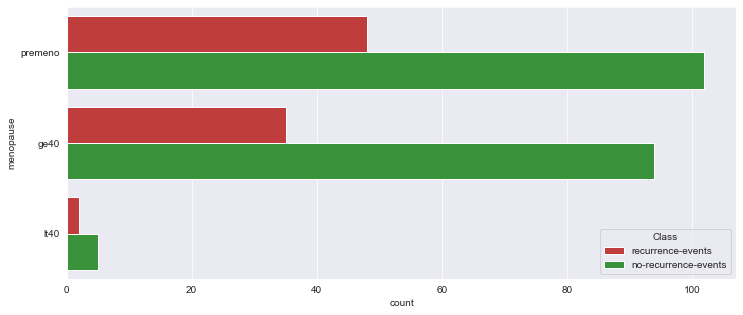

In [15]:
plt.figure(figsize=(12, 5))
sns.countplot(y="menopause", hue="Class", data=data, palette=c_palette)
plt.show()

**Class on Breast**

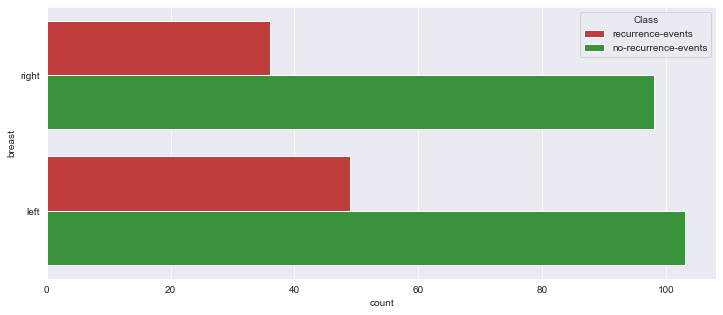

In [16]:
plt.figure(figsize=(12, 5))
sns.countplot(y="breast", hue="Class", data=data, palette=c_palette)
plt.show()

**Class on Breast-Quad**

*Divide par Left/Right breast*

In [17]:
right_b = data.loc[data['breast'] == 'right']
left_b = data.loc[data['breast'] == 'left']

[Text(0, 0.5, 'Right Breast')]

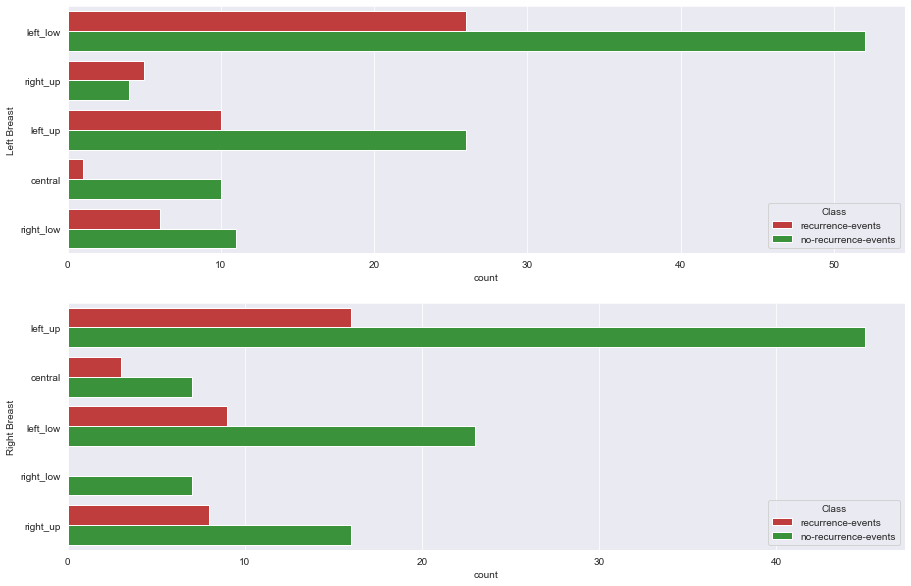

In [18]:
fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(2,1,1)
sns.countplot(y=left_b['breast-quad'], hue="Class", data=data, ax = ax1, palette=c_palette)
ax1.set(ylabel='Left Breast')

ax2 = fig.add_subplot(2,1,2)
sns.countplot(y=right_b['breast-quad'], hue="Class", data=data, ax=ax2, palette=c_palette)
ax2.set(ylabel='Right Breast')

**Class on Degree of Malignancy**

c:\users\enric\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 18.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\users\enric\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 56.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Class', ylabel='deg-malig'>

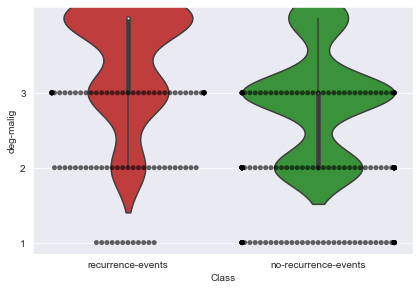

In [19]:
fig = plt.figure(figsize = (15,10))
ax1 = fig.add_subplot(2,2,1)
deg_malig = data['deg-malig'].astype(float)
sns.violinplot(data = data, x='Class', y=deg_malig, ax=ax1, palette=c_palette)
sns.swarmplot(data = data, x='Class', y='deg-malig', color = 'k', alpha = 0.6, ax=ax1)

**Class on Lymph-Nodes**

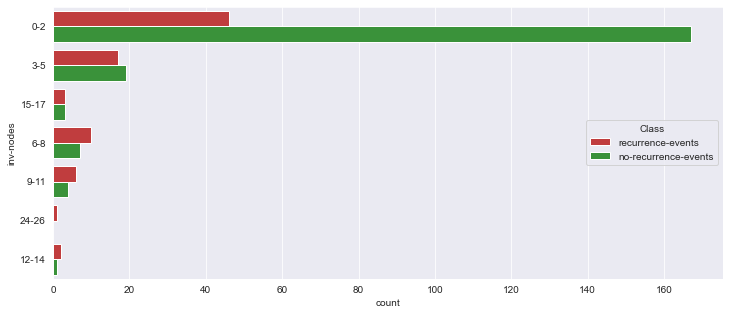

In [20]:
plt.figure(figsize=(12, 5))
sns.countplot(y="inv-nodes", hue="Class", data=data, palette=c_palette)
plt.show()

**Class on Metastases**

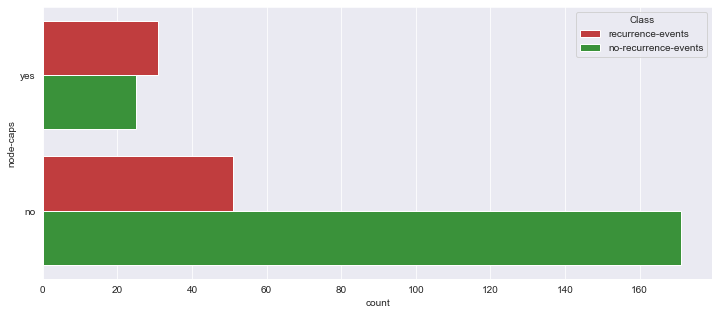

In [21]:
plt.figure(figsize=(12, 5))
sns.countplot(y="node-caps", hue="Class", data=data, palette=c_palette)
plt.show()

**Class on Irradiate**

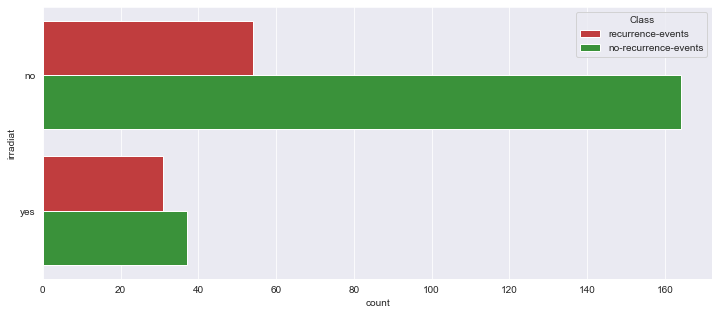

In [22]:
plt.figure(figsize=(12, 5))
sns.countplot(y="irradiat", hue="Class", data=data, palette=c_palette)
plt.show()

# Classifier 

#### Import Libraries

In [208]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

#### General pre-processing

In [178]:
data = pd.read_csv('breast-cancer.csv')
for column in data:
    data[column] = data[column].map(lambda x: x.lstrip("'").rstrip("'"))
data.replace("?", np.nan, inplace = True)
#face with missing values ? 

array(['0-2', '3-5', '15-17', '6-8', '9-11', '24-26', '12-14'],
      dtype=object)

#### Encode Class Feature

In [209]:
#Encode the Class feature to be a binary one
data['Class'][data.Class == 'recurrence-events'] = 1
data['Class'][data.Class == 'no-recurrence-events'] = 0

c:\users\enric\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


#### Preprocess Ordinal Data (LabelEncoder)

In [210]:
#replace binary data
data = data.replace(to_replace=['no', 'yes'], value=['0', '1'])

#preprocess the ordinal data (hierarchy) 
data["age"] = data["age"].map({'20-29':0, '30-39':1, '40-49':2, '50-59':3, '60-69':4, '70-79':5 })

data["inv-nodes"] = data["inv-nodes"].map({'0-2':0, '3-5':1, '6-8':2, '9-11':3, '12-14':4, '15-17':5,'24-26':7})

data["tumor-size"] = data["tumor-size"].map({'0-4':0, '5-9':1, '10-14':2, '15-19':3, '20-24':4, '25-29':5, '30-34':5, '35-39':6, '40-44':7, 
        '45-49':8, '50-54':9 })
data.head()


,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,2,premeno,3,0,1,3,right,left_up,0,1
1,3,ge40,3,0,0,1,right,central,0,0
2,3,ge40,6,0,0,2,left,left_low,0,1
3,2,premeno,6,0,1,3,right,left_low,1,0
4,2,premeno,5,1,1,2,left,right_up,0,1


#### Preprocess Non-Ordinal Data using OneHotEncoding

In [211]:
#processing label with no hierarchy
nominal = ["breast-quad", "breast", "menopause"]
for i in nominal:
    one_hot = pd.get_dummies(data[i])
    data = data.drop(i,axis = 1)
    data = data.join(one_hot)
    
data.head()

,age,tumor-size,inv-nodes,node-caps,deg-malig,irradiat,Class,central,left_low,left_up,right_low,right_up,left,right,ge40,lt40,premeno
0,2,3,0,1,3,0,1,0,0,1,0,0,0,1,0,0,1
1,3,3,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0
2,3,6,0,0,2,0,1,0,1,0,0,0,1,0,1,0,0
3,2,6,0,1,3,1,0,0,1,0,0,0,0,1,0,0,1
4,2,5,1,1,2,0,1,0,0,0,0,1,1,0,0,0,1


#### Split data in train and test

In [212]:
#split the data in attributes and class as well as training and test sets
X = data.drop('Class', axis=1)
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### 1) Decision Tree

In [213]:
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

#### Make prediction 

In [215]:
#Make predicition on test set
y_pred = classifier.predict(X_test)

#Print confusion matrix and other relevant statistics:
print("\n Number of mislabeled points out of a total %d points : %d \n\n"% (X_test.shape[0], (y_test != y_pred).sum()))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


 Number of mislabeled points out of a total 56 points : 18 


[[34  9]
 [ 9  4]]
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        43
           1       0.31      0.31      0.31        13

    accuracy                           0.68        56
   macro avg       0.55      0.55      0.55        56
weighted avg       0.68      0.68      0.68        56



### 2) Naive-Bayes

In [216]:
#Make Gaussian Classifier and fit to data 
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [217]:
#Make predicition on test set
y_pred = classifier.predict(X_test)

#Print confusion matrix and other relevant statistics:
print("\n Number of mislabeled points out of a total %d points : %d \n\n"% (X_test.shape[0], (y_test != y_pred).sum()))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


 Number of mislabeled points out of a total 56 points : 42 


[[ 1 42]
 [ 0 13]]
              precision    recall  f1-score   support

           0       1.00      0.02      0.05        43
           1       0.24      1.00      0.38        13

    accuracy                           0.25        56
   macro avg       0.62      0.51      0.21        56
weighted avg       0.82      0.25      0.12        56



## 3) k-NN

In [223]:
#Number of Neighbors evaluated:
NN = 10

#Make k-NN Classifier and fit to data 
classifier = KNeighborsClassifier(n_neighbors=NN)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [224]:
#Make predicition on test set
y_pred = classifier.predict(X_test)

#Print confusion matrix and other relevant statistics:
print("\n Number of mislabeled points out of a total %d points : %d \n\n"% (X_test.shape[0], (y_test != y_pred).sum()))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


 Number of mislabeled points out of a total 56 points : 11 


[[42  1]
 [10  3]]
              precision    recall  f1-score   support

           0       0.81      0.98      0.88        43
           1       0.75      0.23      0.35        13

    accuracy                           0.80        56
   macro avg       0.78      0.60      0.62        56
weighted avg       0.79      0.80      0.76        56



c:\users\enric\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
c:\users\enric\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\enric\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs

LR: 0.768233 (0.050589)
LDA: 0.773462 (0.051592)
KNN: 0.726555 (0.061821)
CART: 0.696548 (0.056685)
NB: 0.755178 (0.042766)


c:\users\enric\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
c:\users\enric\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
c:\users\enric\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


SVM: 0.760424 (0.052931)


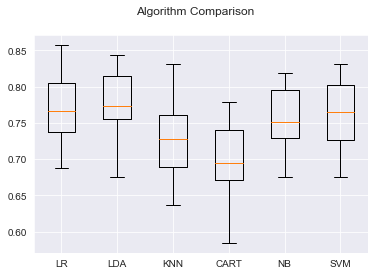

c:\users\enric\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
c:\users\enric\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\enric\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs

LR: 0.768233 (0.050589)
LDA: 0.773462 (0.051592)
KNN: 0.726555 (0.061821)
CART: 0.686176 (0.062783)
NB: 0.755178 (0.042766)

c:\users\enric\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
c:\users\enric\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(



SVM: 0.760424 (0.052931)


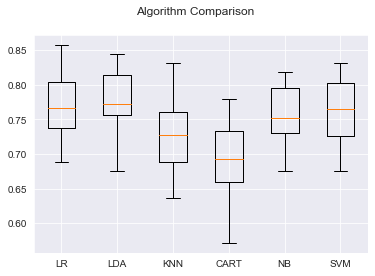

In [225]:

# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()